# Downstream analysis of HPLC-Orbitrap data

This notebook replicates the analysis workflow created by Marc Rurik. The workflow wrapped in [KNIME](https://www.knime.org/) nodes can be found [here](http://www.myexperiment.org/workflows/4792.html), and is illustrated in the picture below. The workflow is developed to analyze HPLC-Orbitrap measurements split into separate or alternating m/z scan ranges. The input expects to be OpenMS consensusXML files, generated by the TextExporter in OpenMS. The workflow further combines the scan ranges, filter them ultilizing blank samples and QC measurements, and then performs statistical analysis to retrieve reliable features.

The aim of this notebook is to give an user friendly and interactive environment where you can get on-the-fly information about the progress of your data. After each step of the pipeline, we provide you with live feedback, consisting of informative plots.

<p align="center">
  <img src="http://www.myexperiment.org/workflows/4792/versions/1/previews/full"/>
</p>

Illustration by: Marc Rurik

* Source .rscripts

In [1]:
source('../reproducing/Functions.R')

[1] "The functions were succesfully loaded"


In [2]:
library(R.utils)

Warning message:
"package 'R.utils' was built under R version 3.3.3"Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.7.1 (2016-02-15) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.21.0 (2016-10-30) successfully loaded. See ?R.oo for help.

Attaching package: 'R.oo'

The following objects are masked from 'package:methods':

    getClasses, getMethods

The following objects are masked from 'package:base':

    attach, detach, gc, load, save

R.utils v2.5.0 (2016-11-07) successfully loaded. See ?R.utils for help.

Attaching package: 'R.utils'

The following object is masked from 'package:utils':

    timestamp

The following objects are masked from 'package:base':

    cat, commandArgs, getOption, inherits, isOpen, parse, warnings



### Alternate

* Read files

In [3]:
nL_low <- countLines("data/alternate_neg_low_mr.csv")
nL_low = read.csv("data/alternate_neg_low_mr.csv", 
                skip=nL_low-1,
                fill=TRUE,
                sep="")
alt_low = read.csv("data/alternate_neg_low_mr.csv", 
               header = FALSE, comment.char="#",
               stringsAsFactors = FALSE, 
               fill=TRUE, 
               col.names= paste0("V",seq_len(length(nL_low))), 
               sep="")

nL_high <- countLines("data/alternate_neg_high_mr.csv")
nL_high = read.csv("data/alternate_neg_high_mr.csv", 
                skip=nL_high-1,
                fill=TRUE,
                sep="")
alt_high = read.csv("data/alternate_neg_high_mr.csv", 
               header = FALSE, comment.char="#",
               stringsAsFactors = FALSE, 
               fill=TRUE, 
               col.names= paste0("V",seq_len(length(nL_high))), 
               sep="")
dim(alt_low)
dim(alt_high)

[1] 1660  227

[1] 3022  227

* Parse the files

In [4]:
alt_low <- Parse(alt_low)
alt_high <- Parse(alt_high)
cat("Size of low mass range matrix:", dim(alt_low), "\n")
cat("Size of high mass range matrix: ", dim(alt_high))
head(alt_low)

Size of low mass range matrix: 1616 46 
Size of high mass range matrix:  2978 46

,mz,rt,001_CRa_H9M5_M470_Blank_01_alternate_neg_low_mr.featureXML,002_CRa_H9M5_M470_Pool_01_alternate_neg_low_mr.featureXML,003_CRa_H9M5_M470_Pool_02_alternate_neg_low_mr.featureXML,005_CRa_H9M5_M470_Blank_02_alternate_neg_low_mr.featureXML,006_CRa_H9M5_M470_H01_K1_alternate_neg_low_mr.featureXML,007_CRa_H9M5_M470_L01_K2_alternate_neg_low_mr.featureXML,008_CRa_H9M5_M470_H14_K1_alternate_neg_low_mr.featureXML,009_CRa_H9M5_M470_Blank_03_alternate_neg_low_mr.featureXML,...,037_CRa_H9M5_M470_Blank_09_alternate_neg_low_mr.featureXML,038_CRa_H9M5_M470_L14_K3_alternate_neg_low_mr.featureXML,039_CRa_H9M5_M470_C03_K2_alternate_neg_low_mr.featureXML,040_CRa_H9M5_M470_L03_K1_alternate_neg_low_mr.featureXML,041_CRa_H9M5_M470_Blank_10_alternate_neg_low_mr.featureXML,042_CRa_H9M5_M470_Pool_06_alternate_neg_low_mr.featureXML,044_CRa_H9M5_M470_L14_K1_alternate_neg_low_mr.featureXML,045_CRa_H9M5_M470_L14_K2_alternate_neg_low_mr.featureXML,046_CRa_H9M5_M470_H03_K3_alternate_neg_low_mr.featureXML,047_CRa_H9M5_M470_Blank_11_alternate_neg_low_mr.featureXML
27,56.9429851819502,710.113227272727,18927.19921875,20134,20360.80078125,15372.2998046875,20526.19921875,18517.400390625,19277.400390625,22927.30078125,...,22445.30078125,23209,24879.900390625,23802.5,21664.30078125,21404.80078125,25398.5,21752,21651.099609375,27390.099609375
1467,58.0295040119917,74.536,NaN,NaN,NaN,NaN,NaN,NaN,7365.66015625,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3168.09008789062,NaN
916,58.9586458312938,565.272975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4813.02978515625,6176.58984375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22544.30078125
1192,58.9586469983477,521.635114285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12063.2001953125,17844,NaN,NaN,NaN,NaN,NaN,NaN,5176.2001953125,NaN
91,58.9586501941959,710.033857142857,NaN,NaN,173801,168457,153281,158480,165731,163037,...,185301,167221,180394,163692,179156,173668,173047,191275,179950,195755
1563,58.9586532246558,540.7544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21812.30078125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37453.6015625,23703.80078125


* Rename columns

In [5]:
alt_low <- renameColumns(alt_low)
alt_high <- renameColumns(alt_high)

if (ncol(alt_low)!=ncol(alt_high)) {
    if (ncol(alt_low>ncol(alt_high))) {
        warning("Samples are missing in the high mass range")
    } else {
        warning("Samples are missing in the low mass range")
    }
}

print(names(alt_low))

 [1] "mz"       "rt"       "Blank_01" "Pool_01"  "Pool_02"  "Blank_02"
 [7] "H01_K1"   "L01_K2"   "H14_K1"   "Blank_03" "L03_K3"   "C14_K2"  
[13] "C01_K1"   "Blank_04" "Pool_03"  "H14_K2"   "H01_K2"   "H03_K1"  
[19] "Blank_05" "C01_K3"   "C14_K3"   "L03_K2"   "Blank_06" "Pool_04" 
[25] "C03_K1"   "H03_K2"   "H14_K3"   "Blank_07" "L01_K3"   "C14_K1"  
[31] "H01_K3"   "Blank_08" "Pool_05"  "L01_K1"   "C01_K2"   "C03_K3"  
[37] "Blank_09" "L14_K3"   "C03_K2"   "L03_K1"   "Blank_10" "Pool_06" 
[43] "L14_K1"   "L14_K2"   "H03_K3"   "Blank_11"


* Concatenate the scan ranges

In [6]:
alt_neg <- rbind(alt_low, alt_high[,names(alt_low)])
names(alt_neg)<-gsub("_",".",names(alt_neg))
cat("Number of features: ", nrow(alt_neg))

alt_neg[alt_neg=="NaN"]=NA
alt_neg <- data.frame(apply(alt_neg,2,as.numeric))

Number of features:  4594

* Blank Filter and ConsensusMap normalization

In [7]:
blankFilterPassed = 20 #Percentage, if the median blank intesity is more than X% of the sample intensity --> contaminant 
alt_neg <- blankFilter(alt_neg,blankFilterPassed)

# set parameters for normalization
ignoreColsPattern = c("TCA", "Blank")
method = "mean"
outlier = c(0.68, 1/0.68)
verbose = FALSE

alt_neg_norm <- consensusMapNormalization(alt_neg, ignoreColsPattern, method, outlier, verbose)

259 number of features passed 


* Filtering on pools, RSD and biological replicates and handle missing values

In [8]:
# set parameters
poolFilterCount = 5
biolReplFilterCount = 2
numReplicates = 3
maxRSD = 25

alt_neg_norm <- QAFilter(alt_neg_norm$df, poolFilterCount, biolReplFilterCount, numReplicates, maxRSD)
cat(nrow(alt_neg_norm), "number of features left")

# Handle missing values
alt_neg_norm <- missingValues(alt_neg_norm)

190 number of features left

* Plot figure 3 in the paper

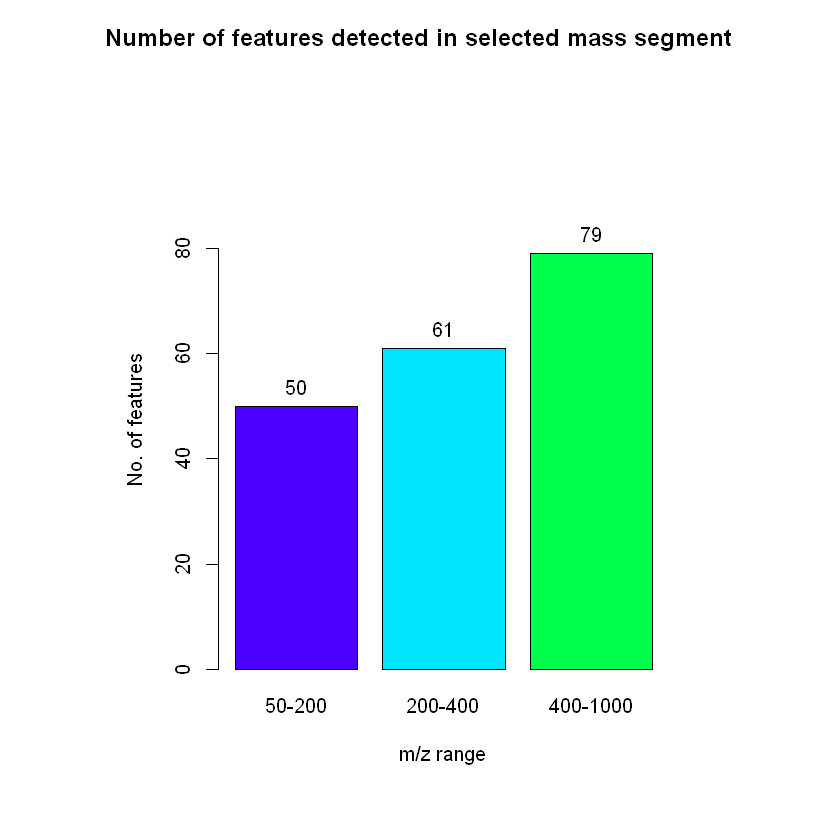

In [9]:
low_mass <- sum(as.numeric(alt_neg_norm$mz)<200)
mid_mass <- sum(as.numeric(alt_neg_norm$mz)>200 & as.numeric(alt_neg_norm$mz)<400)
high_mass <- sum(as.numeric(alt_neg_norm$mz)>400 & as.numeric(alt_neg_norm$mz)<1000)

data <- data.frame(x=c("50-200", "200-400", "400-1000"), 
                   y=c(low_mass,mid_mass,high_mass))
#data$y <- c(56,81,91)
ylimit <- c(0, 1.2*max(data$y))
par(oma=c(2,5,3,5))
xx <- barplot(data$y, 
              names.arg=data$x, 
              ylim=ylimit,
              ylab="No. of features", 
              xlab="m/z range",
              col=topo.colors(6))
text(x=xx,
     y=data$y,
     label=data$y,
     pos = 3)
title("Number of features detected in selected mass segment", outer = TRUE)

### Seperate

* Read input

In [10]:
nL_low <- countLines("data/low_neg.csv")
nL_low = read.csv("data/low_neg.csv", 
                skip=nL_low-1,
                fill=TRUE,
                sep="")
sep_low = read.csv("data/low_neg.csv", 
               header = FALSE, comment.char="#",
               stringsAsFactors = FALSE, 
               fill=TRUE, 
               col.names= paste0("V",seq_len(length(nL_low))), 
               sep="")

nL_high <- countLines("data/high_neg.csv")
nL_high = read.csv("data/high_neg.csv", 
                skip=nL_high-1,
                fill=TRUE,
                sep="")
sep_high = read.csv("data/high_neg.csv", 
               header = FALSE, comment.char="#",
               stringsAsFactors = FALSE, 
               fill=TRUE, 
               col.names= paste0("V",seq_len(length(nL_high))), 
               sep="")
dim(sep_low)
dim(sep_high)

[1] 5428  227

[1] 4502  227

* Parse files

In [11]:
sep_low <- Parse(sep_low)
sep_high <- Parse(sep_high)
cat("Size of low mass range matrix:", dim(sep_low), "\n")
cat("Size of high mass range matrix: ", dim(sep_high))
head(sep_low)

Size of low mass range matrix: 5384 46 
Size of high mass range matrix:  4458 46

,mz,rt,001_CRa_H9M5_M470_Blank_01_low_neg.featureXML,002_CRa_H9M5_M470_Pool_01_low_neg.featureXML,003_CRa_H9M5_M470_Pool_02_low_neg.featureXML,005_CRa_H9M5_M470_Blank_02_low_neg.featureXML,006_CRa_H9M5_M470_H01_K1_low_neg.featureXML,007_CRa_H9M5_M470_L01_K2_low_neg.featureXML,008_CRa_H9M5_M470_H14_K1_low_neg.featureXML,009_CRa_H9M5_M470_Blank_03_low_neg.featureXML,...,037_CRa_H9M5_M470_Blank_09_low_neg.featureXML,038_CRa_H9M5_M470_L14_K3_low_neg.featureXML,039_CRa_H9M5_M470_C03_K2_low_neg.featureXML,040_CRa_H9M5_M470_L03_K1_low_neg.featureXML,041_CRa_H9M5_M470_Blank_10_low_neg.featureXML,042_CRa_H9M5_M470_Pool_06_low_neg.featureXML,044_CRa_H9M5_M470_L14_K1_low_neg.featureXML,045_CRa_H9M5_M470_L14_K2_low_neg.featureXML,046_CRa_H9M5_M470_H03_K3_low_neg.featureXML,047_CRa_H9M5_M470_Blank_11_low_neg.featureXML
5144,58.9586548224691,710.999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3812.46997070312,NaN,NaN
3815,60.992807818433,72.3887142857143,23699.900390625,NaN,38124.5,NaN,NaN,50646.19921875,39192.80078125,NaN,...,NaN,NaN,43277.19921875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,60.992813602335,50.4222075,22629.80078125,NaN,22382.900390625,53088.6015625,23516.80078125,NaN,63003.8984375,NaN,...,NaN,25815,18546.80078125,21273.400390625,NaN,23219.19921875,22932.400390625,22445.5,22554,NaN
3767,60.9928152252259,218.346514285714,210944,NaN,NaN,NaN,NaN,166293,80074.796875,NaN,...,NaN,NaN,101496,377621,NaN,NaN,NaN,NaN,NaN,NaN
29,64.9455073190324,706.981227272727,4358.7998046875,3483.96997070312,4317.89013671875,5649.759765625,4655,3658.30004882812,4709.83984375,5243.58984375,...,6715.8798828125,7386.009765625,6543.009765625,7026.2099609375,6351.81982421875,7634.22021484375,7775.35986328125,7536.89013671875,7042.77978515625,6573.60986328125
5376,65.9982541686323,591.7149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,922.703979492188,NaN,2229.61010742188,3276.82006835938,2823.11010742188,741.877014160156,2658.3701171875


* Rename columns

In [12]:
sep_low <- renameColumns(sep_low)
sep_high <- renameColumns(sep_high)

if (ncol(sep_low)!=ncol(sep_high)) {
    if (ncol(sep_low>ncol(sep_high))) {
        warning("Samples are missing in the high mass range")
    } else {
        warning("Samples are missing in the low mass range")
    }
}

print(names(sep_low))

 [1] "mz"       "rt"       "Blank_01" "Pool_01"  "Pool_02"  "Blank_02"
 [7] "H01_K1"   "L01_K2"   "H14_K1"   "Blank_03" "L03_K3"   "C14_K2"  
[13] "C01_K1"   "Blank_04" "Pool_03"  "H14_K2"   "H01_K2"   "H03_K1"  
[19] "Blank_05" "C01_K3"   "C14_K3"   "L03_K2"   "Blank_06" "Pool_04" 
[25] "C03_K1"   "H03_K2"   "H14_K3"   "Blank_07" "L01_K3"   "C14_K1"  
[31] "H01_K3"   "Blank_08" "Pool_05"  "L01_K1"   "C01_K2"   "C03_K3"  
[37] "Blank_09" "L14_K3"   "C03_K2"   "L03_K1"   "Blank_10" "Pool_06" 
[43] "L14_K1"   "L14_K2"   "H03_K3"   "Blank_11"


* Concatenate the scan ranges

In [13]:
sep_neg <- rbind(sep_low, sep_high[,names(sep_low)])
names(sep_neg)<-gsub("_",".",names(sep_neg))
cat("Number of features: ", nrow(sep_neg))

sep_neg[sep_neg=="NaN"]=NA
sep_neg <- data.frame(apply(sep_neg,2,as.numeric))

Number of features:  9842

* Blank Filter and ConsensusMap normalization

In [14]:
blankFilterPassed = 20 #Percentage, if the median blank intesity is more than X% of the sample intensity --> contaminant 
sep_neg <- blankFilter(sep_neg,blankFilterPassed)

# set parameters for normalization
ignoreColsPattern = c("TCA", "Blank")
method = "mean"
outlier = c(0.68, 1/0.68)
verbose = FALSE

sep_neg_norm <- consensusMapNormalization(sep_neg, ignoreColsPattern, method, outlier, verbose)

347 number of features passed 


* Filtering on pools, RSD and biological replicates and handle missing values

In [15]:
# set parameters
poolFilterCount = 5
biolReplFilterCount = 2
numReplicates = 3
maxRSD = 25

sep_neg_norm <- QAFilter(sep_neg_norm$df, poolFilterCount, biolReplFilterCount, numReplicates, maxRSD)
cat(nrow(sep_neg_norm), "number of features left")

# Handle missing values
sep_neg_norm <- missingValues(sep_neg_norm)

248 number of features left

* Plot figure 3

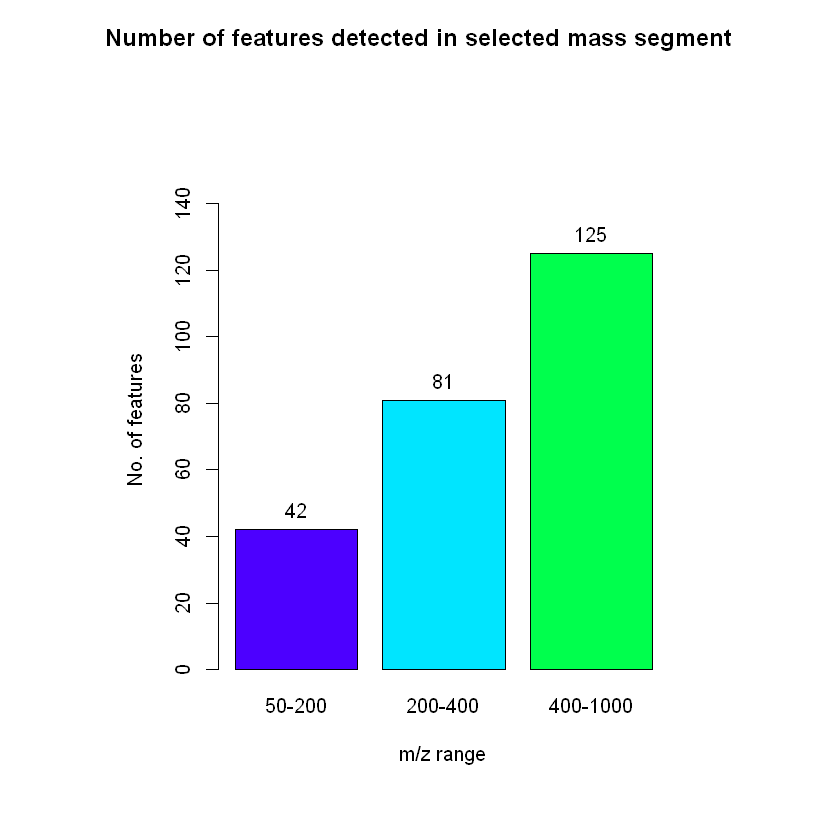

In [16]:
low_mass <- sum(as.numeric(sep_neg_norm$mz)<200)
mid_mass <- sum(as.numeric(sep_neg_norm$mz)>200 & as.numeric(sep_neg_norm$mz)<400)
high_mass <- sum(as.numeric(sep_neg_norm$mz)>400 & as.numeric(sep_neg_norm$mz)<1000)

data <- data.frame(x=c("50-200", "200-400", "400-1000"), 
                   y=c(low_mass,mid_mass,high_mass))
#data$y <- c(90,204,134)
ylimit <- c(0, 1.2*max(data$y))
par(oma=c(2,5,3,5))
xx <- barplot(data$y, 
              names.arg=data$x, 
              ylim=ylimit,
              ylab="No. of features", 
              xlab="m/z range",
              col=topo.colors(6))
text(x=xx,
     y=data$y,
     label=data$y,
     pos = 3)
title("Number of features detected in selected mass segment", outer = TRUE)

### Full scan approach

In [17]:
nL <- countLines("data/ges_neg.csv")
nL = read.csv("data/ges_neg.csv", 
                skip=nL-1,
                fill=TRUE,
                sep="")
full_neg = read.csv("data/ges_neg.csv", 
               header = FALSE, comment.char="#",
               stringsAsFactors = FALSE, 
               fill=TRUE, 
               col.names= paste0("V",seq_len(length(nL))), 
               sep="")
dim(full_neg)

[1] 5356  227

* Parse file

In [18]:
full_neg <- Parse(full_neg)
cat("Size of mass range matrix: ", dim(full_neg))
head(full_neg)

Size of mass range matrix:  5312 46

,mz,rt,001_CRa_H9M5_M470_Blank_01_ges_neg.featureXML,002_CRa_H9M5_M470_Pool_01_ges_neg.featureXML,003_CRa_H9M5_M470_Pool_02_ges_neg.featureXML,005_CRa_H9M5_M470_Blank_02_ges_neg.featureXML,006_CRa_H9M5_M470_H01_K1_ges_neg.featureXML,007_CRa_H9M5_M470_L01_K2_ges_neg.featureXML,008_CRa_H9M5_M470_H14_K1_ges_neg.featureXML,009_CRa_H9M5_M470_Blank_03_ges_neg.featureXML,...,037_CRa_H9M5_M470_Blank_09_ges_neg.featureXML,038_CRa_H9M5_M470_L14_K3_ges_neg.featureXML,039_CRa_H9M5_M470_C03_K2_ges_neg.featureXML,040_CRa_H9M5_M470_L03_K1_ges_neg.featureXML,041_CRa_H9M5_M470_Blank_10_ges_neg.featureXML,042_CRa_H9M5_M470_Pool_06_ges_neg.featureXML,044_CRa_H9M5_M470_L14_K1_ges_neg.featureXML,045_CRa_H9M5_M470_L14_K2_ges_neg.featureXML,046_CRa_H9M5_M470_H03_K3_ges_neg.featureXML,047_CRa_H9M5_M470_Blank_11_ges_neg.featureXML
280,56.9429787263614,709.921363636364,10455.400390625,18454.099609375,17774.30078125,17379.69921875,16286.2998046875,16251.400390625,19989,21714.099609375,...,22707.19921875,24116.80078125,18584.099609375,21422.69921875,22134.30078125,19194.69921875,17659.30078125,23499.19921875,21718.099609375,20344
1806,57.9617383779704,706.4504,1685.98999023438,1662.43994140625,NaN,1434.89001464844,NaN,1455.16003417969,NaN,NaN,...,1726.97998046875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1662.90002441406
4976,58.0295005903593,74.5949,NaN,NaN,NaN,NaN,NaN,NaN,5282.47021484375,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2767.85009765625,NaN
3210,58.9586318059193,569.822666666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7093.02978515625,3340.57006835938,10049,NaN,NaN,NaN,4566.89013671875,NaN,NaN
3207,58.958635031142,520.984733333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6526.93994140625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4410,58.9586355645445,596.306914285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4532.7001953125,NaN,1792.72998046875,NaN,NaN,NaN,NaN,4543.27001953125,NaN


* Rename columns

In [19]:
full_neg <- renameColumns(full_neg)
print(names(full_neg))

 [1] "mz"       "rt"       "Blank_01" "Pool_01"  "Pool_02"  "Blank_02"
 [7] "H01_K1"   "L01_K2"   "H14_K1"   "Blank_03" "L03_K3"   "C14_K2"  
[13] "C01_K1"   "Blank_04" "Pool_03"  "H14_K2"   "H01_K2"   "H03_K1"  
[19] "Blank_05" "C01_K3"   "C14_K3"   "L03_K2"   "Blank_06" "Pool_04" 
[25] "C03_K1"   "H03_K2"   "H14_K3"   "Blank_07" "L01_K3"   "C14_K1"  
[31] "H01_K3"   "Blank_08" "Pool_05"  "L01_K1"   "C01_K2"   "C03_K3"  
[37] "Blank_09" "L14_K3"   "C03_K2"   "L03_K1"   "Blank_10" "Pool_06" 
[43] "L14_K1"   "L14_K2"   "H03_K3"   "Blank_11"


In [20]:
names(full_neg)<-gsub("_",".",names(full_neg))
cat("Number of features: ", nrow(full_neg))

full_neg[full_neg=="NaN"]=NA
full_neg <- data.frame(apply(full_neg,2,as.numeric))

Number of features:  5312

* Blank Filter and ConsensusMap normalization

In [21]:
blankFilterPassed = 20 #Percentage, if the median blank intesity is more than X% of the sample intensity --> contaminant 
full_neg <- blankFilter(full_neg,blankFilterPassed)

# set parameters for normalization
ignoreColsPattern = c("TCA", "Blank")
method = "mean"
outlier = c(0.68, 1/0.68)
verbose = FALSE

full_neg_norm <- consensusMapNormalization(full_neg, ignoreColsPattern, method, outlier, verbose)

242 number of features passed 


* Filtering on pools, RSD and biological replicates and handle missing values

In [22]:
# set parameters
poolFilterCount = 5
biolReplFilterCount = 2
numReplicates = 3
maxRSD = 25

full_neg_norm <- QAFilter(full_neg_norm$df, poolFilterCount, biolReplFilterCount, numReplicates, maxRSD)
cat(nrow(full_neg_norm), "number of features left")

# Handle missing values
full_neg_norm <- missingValues(full_neg_norm)

190 number of features left

* Plot figure 3

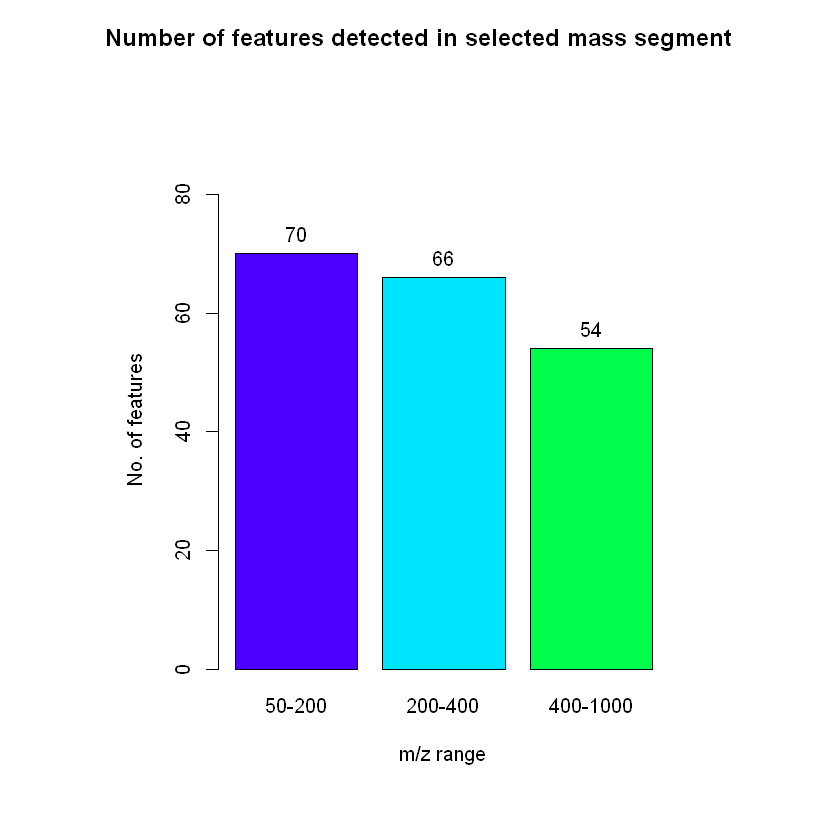

In [23]:
low_mass <- sum(as.numeric(full_neg_norm$mz)<200)
mid_mass <- sum(as.numeric(full_neg_norm$mz)>200 & as.numeric(full_neg_norm$mz)<400)
high_mass <- sum(as.numeric(full_neg_norm$mz)>400 & as.numeric(full_neg_norm$mz)<1000)

data <- data.frame(x=c("50-200", "200-400", "400-1000"), 
                   y=c(low_mass,mid_mass,high_mass))
#data$y <- c(83,82,60)
ylimit <- c(0, 1.2*max(data$y))
par(oma=c(2,5,3,5))
xx <- barplot(data$y, 
              names.arg=data$x, 
              ylim=ylimit,
              ylab="No. of features", 
              xlab="m/z range",
              col=topo.colors(6))
text(x=xx,
     y=data$y,
     label=data$y,
     pos = 3)
title("Number of features detected in selected mass segment", outer = TRUE)

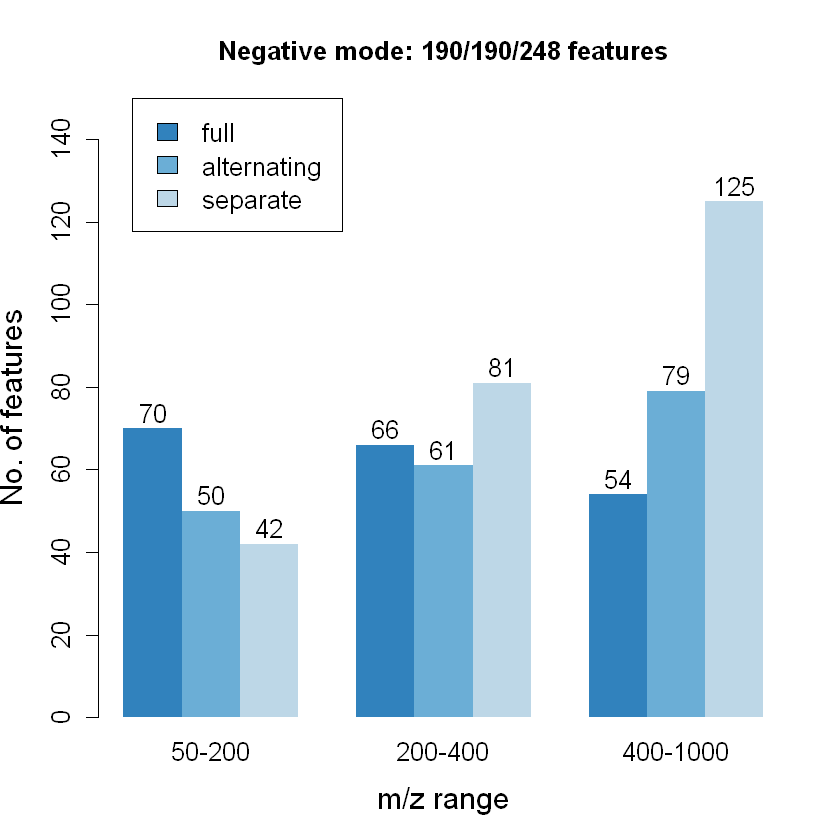

In [30]:
low_mass <- sum(as.numeric(alt_neg_norm$mz)<200)
mid_mass <- sum(as.numeric(alt_neg_norm$mz)>200 & as.numeric(alt_neg_norm$mz)<400)
high_mass <- sum(as.numeric(alt_neg_norm$mz)>400 & as.numeric(alt_neg_norm$mz)<1000)
alt <- data.frame(low_mass,mid_mass,high_mass)
names(alt) <- c("50-200", "200-400", "400-1000")
row.names(alt) <- "alternating"                

low_mass <- sum(as.numeric(sep_neg_norm$mz)<200)
mid_mass <- sum(as.numeric(sep_neg_norm$mz)>200 & as.numeric(sep_neg_norm$mz)<400)
high_mass <- sum(as.numeric(sep_neg_norm$mz)>400 & as.numeric(sep_neg_norm$mz)<1000)
sep <- data.frame(low_mass,mid_mass,high_mass)
names(sep) <- c("50-200", "200-400", "400-1000")
row.names(sep) <- "separate"  

low_mass <- sum(as.numeric(full_neg_norm$mz)<200)
mid_mass <- sum(as.numeric(full_neg_norm$mz)>200 & as.numeric(full_neg_norm$mz)<400)
high_mass <- sum(as.numeric(full_neg_norm$mz)>400 & as.numeric(full_neg_norm$mz)<1000)
full <- data.frame(low_mass,mid_mass,high_mass)
names(full) <- c("50-200", "200-400", "400-1000")
row.names(full) <- "full"  

data <- data.frame(rbind(full,alt,sep))
names(data) <- c("50-200", "200-400", "400-1000")

library(RColorBrewer)
myColours <- brewer.pal(5,"Blues")

ylimit <- c(0, 1.2*max(data))
#par(oma=c(2,5,3,5))
xx<-barplot(as.matrix(data), col= rev(brewer.pal(5,"Blues")[c(2,3,4)]), width=2, beside=TRUE,border=NA,
        ylab="No. of features", xlab="m/z range", ylim=ylimit, main="Negative mode: 190/190/248 features",
            cex.axis=1.3, cex.names=1.3, cex.lab=1.5, cex.main=1.3)
legend("topleft",inset=c(0.05,0), fill=rev(brewer.pal(5,"Blues")[c(2,3,4)]), legend=rownames(data), cex=1.3)

test <- c(70,50,42,66,61,81,54,79,125)
text(c(3,5,7),c(74,54,46),c("70","50","42"), cex=1.3)
text(c(11,13,15),c(70,65,85),c("66","61","81"), cex=1.3)
text(c(19,21,23),c(58,83,129),c("54","79","125"), cex=1.3)


In [ ]:
save.image("downstream_neg.RData")